In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import uproot

from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import roc_curve, auc
import warnings
warnings.simplefilter(action='ignore')


In [10]:
file = uproot.open("../tmva_training/trees/background_ztautau_Z0_nano_mutau_2016_2017_2018_8.tree")
file.keys()

['tree_8;132', 'background_tree;1']

In [12]:
tree = file["background_tree"]

In [13]:
tree.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
leponept             | float                    | AsDtype('>f4')
leponeptoverm        | float                    | AsDtype('>f4')
leponeeta            | float                    | AsDtype('>f4')
leponed0             | float                    | AsDtype('>f4')
leptwopt             | float                    | AsDtype('>f4')
leptwoptoverm        | float                    | AsDtype('>f4')
leptwoeta            | float                    | AsDtype('>f4')
leptwod0             | float                    | AsDtype('>f4')
leppt                | float                    | AsDtype('>f4')
lepm                 | float                    | AsDtype('>f4')
lepptoverm           | float                    | AsDtype('>f4')
lepeta               | float                    | AsDtype('>f4')
lepdeltaeta          | float                    | AsDtype(

In [38]:
data = tree.arrays(["issignal","leponeprimepz0", "leponeprimee0", "leptwoprimepx0", "leptwoprimepz0", "leptwoprimee0", "metprimee0", "lepm", "lepmestimate","deltaalphaz2"], library="pd")

In [39]:
data.head()

,issignal,leponeprimepz0,leponeprimee0,leptwoprimepx0,leptwoprimepz0,leptwoprimee0,metprimee0,lepm,lepmestimate,deltaalphaz2
0,-1.0,-26.753578,43.379353,-28.068172,14.138433,44.466560,14.746703,85.675537,85.675537,-1.471326
1,-1.0,12.692028,25.026943,-41.141609,69.342896,80.707962,19.850487,63.687511,63.687511,0.697536
2,-1.0,-1.259534,31.713039,-25.827244,3.242361,40.793461,21.633057,69.175659,69.175659,0.965933
3,-1.0,15.473433,40.311726,26.314241,34.156406,44.537109,9.208794,68.201187,78.441765,-0.066308
4,-1.0,11.082369,35.894814,13.050830,47.534008,57.673565,3.375119,72.854446,74.703079,0.208333


In [40]:
data["issignal"] = (data["issignal"] > 0.5) * 1

In [41]:
data.head()

,issignal,leponeprimepz0,leponeprimee0,leptwoprimepx0,leptwoprimepz0,leptwoprimee0,metprimee0,lepm,lepmestimate,deltaalphaz2
0,0,-26.753578,43.379353,-28.068172,14.138433,44.466560,14.746703,85.675537,85.675537,-1.471326
1,0,12.692028,25.026943,-41.141609,69.342896,80.707962,19.850487,63.687511,63.687511,0.697536
2,0,-1.259534,31.713039,-25.827244,3.242361,40.793461,21.633057,69.175659,69.175659,0.965933
3,0,15.473433,40.311726,26.314241,34.156406,44.537109,9.208794,68.201187,78.441765,-0.066308
4,0,11.082369,35.894814,13.050830,47.534008,57.673565,3.375119,72.854446,74.703079,0.208333


In [43]:
X,y=data.loc[:, data.columns != 'issignal'].to_numpy(),data.loc[:, data.columns == 'issignal'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
from sklearn.neural_network import MLPClassifier

## Classifier Training 
MLPClassifier is a class in scikit learn package that implements a multi-layer perceptron (MLP) algorithm that trains using Backpropagation. 

Below is an example of how to train a MLPClassifier and a list of parameters we can choose.

Ref: [1]

In [65]:
MVA_LBFGS = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(3,10), random_state=1)
MVA_LBFGS.fit(X_train,y_train)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(3, 10), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=1, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

Among the many parameters we are allowed to choose when training the classifier, we focus on the choice of algorithm, the number of layers, and number of neurons per layer.

Here we need to sweep through a range of values for each parameter, thus define some useful functions to train classifier, calculate accuracy, and produce heatmap for each choice of parameter we make.

Ref: [2]

In [51]:
def MVA_Classifier(layer_size,solver):
    #solver: can be lbfgs or sgd
    #layerz_size: (# of neurons per layer, # of layers)
    MVA_classifier = MLPClassifier(solver=solver, alpha=1e-5, hidden_layer_sizes=layer_size, random_state=1)
    MVA_classifier.fit(X_train, y_train)                         
    return MVA_classifier

In [57]:
def accuracy_matrix(l_range, n_range,solver,data_X,data_y):
    a_m=np.zeros((len(l_range),len(n_range)))
    for l in range(len(l_range)):
        for n in range(len(n_range)):
            print("Training MVA with", l_range[l], "layers of", n_range[n], "neurons")
            a_m[l,n] = MVA_Classifier((n_range[n],l_range[l]),solver).score(data_X,data_y)
    return a_m

In [58]:
def plot_accuracy(am,fsize,digit,title):
    fig, ax = plt.subplots(figsize=(fsize,fsize))
    im = ax.imshow(am,vmin = 0.0,vmax = 1.0)
    cbar = ax.figure.colorbar(im)
    cbar.ax.set_ylabel('accuracy') 
    ax.set_xticks(np.arange(am.shape[1]))
    ax.set_yticks(np.arange(am.shape[0]))
    ax.set_xticklabels(range(1,am.shape[1]+1))
    ax.set_yticklabels(range(1,am.shape[0]+1))
    ax.tick_params(top=True, bottom=False,labeltop=True, labelbottom=False)
    ax.xaxis.set_label_position('top') 
    ax.set_ylabel('# of layers',fontsize = 14)
    ax.set_xlabel('# of neurons per layer',fontsize = 14)
    for i in range(am.shape[0]):
        for j in range(am.shape[1]):
            text = ax.text(j, i, np.round(am[i, j],digit),ha="center", va="center", color="w")
    plt.title(title, fontsize = 24)
    plt.show()

## Algo Choice 1: Limited-memory BFGS (L-BFGS)
Limited-memory BFGS (L-BFGS) is an algorithm in the Newton's Methods family. Like the regular Newton's Methods, L-BFGS also uses Hessian for parameter updates, but with less usage of computer resource.

Ref: [3] [4]

In [59]:
a_lbfgs_train = accuracy_matrix(range(1,3),range(1,5),'lbfgs',X_train,y_train)

Training MVA with 1 layers of 2 neurons
Training MVA with 1 layers of 3 neurons
Training MVA with 1 layers of 4 neurons
Training MVA with 2 layers of 2 neurons
Training MVA with 2 layers of 3 neurons
Training MVA with 2 layers of 4 neurons


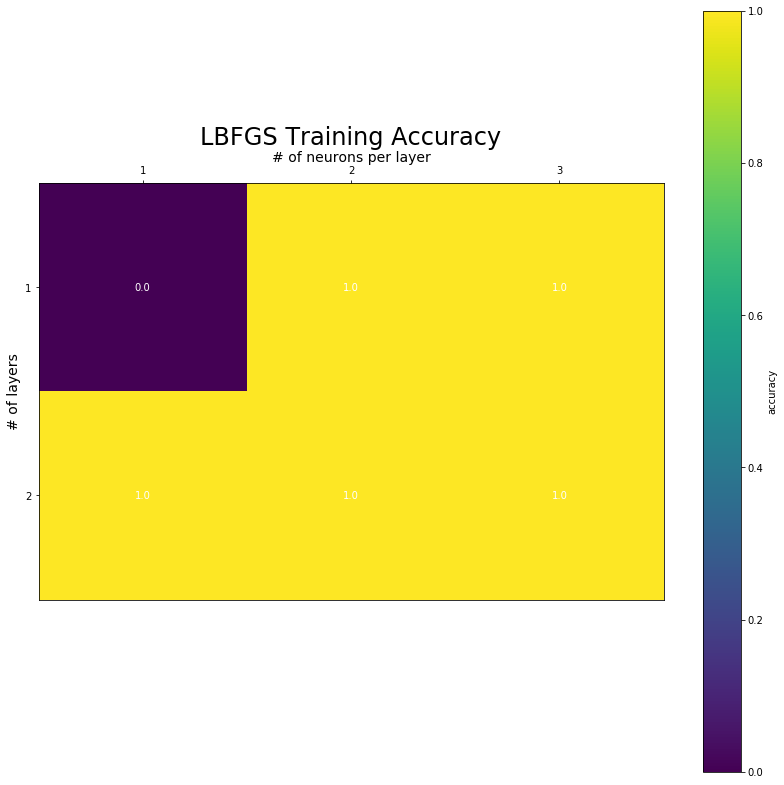

array([[0.00186265, 0.99813735, 0.99772294],
       [0.99813735, 0.99813735, 0.99813735]])

In [63]:
plot_accuracy(a_lbfgs_train,14,2,'LBFGS Training Accuracy')
a_lbfgs_train

In [72]:
def plot_roc(MVA):
    fpr, tpr, threshold = roc_curve(y_test, MVA.predict_proba(X_test)[:,1])
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
MVA_LBFGS = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(20,20,10,10,5,5,5), random_state=1)
MVA_LBFGS.fit(X_train,y_train)
plot_roc(MVA_LBFGS)
MVA_LBFGS.n_layers_

In [84]:
MVA_LBFGS.n_layers_

4